# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn import metrics
from sklearn.linear_model import Ridge

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [224]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [225]:
azdias_20_per = int(azdias.shape[0]*0.2)
customers_20_per = int(customers.shape[0]*0.2)

In [227]:
azdias_b = azdias.head(azdias_20_per)
customers_b = customers.head(customers_20_per)


In [4]:
azdias_b.to_csv("azdias_b.csv")
customers_b.to_csv("customers_b.csv")

NameError: name 'azdias_b' is not defined

In [228]:
azdias_b.shape,customers_b.shape

((178244, 366), (38330, 369))

In [2]:
azdias = pd.read_csv("azdias_b.csv")
customers = pd.read_csv("customers_b.csv")

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
customers.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [3]:
dis_attributues = pd.read_excel("DIAS Attributes - Values 2017.xlsx")
dis_information_level = pd.read_excel("DIAS Information Levels - Attributes 2017.xlsx")

In [15]:
dis_attributues.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [4]:
azdias = azdias.drop(["Unnamed: 0"],axis=1)
customers = customers.drop(["Unnamed: 0"],axis=1)

In [6]:
azdias.select_dtypes(['object']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W


### Part 0.1: Clean Data
In order to clean data we do the following steps:

1. There are some values in the data which are labeled as uknown in the information excel file DIAS Attributes. These unkown values which take the values of 0,-1 and 9 in different columns need to be replaced by NaN values, as they don't contain any information and they are meaningless. So first step is to find these values and replace them with NaN. 


2. There are two columns asscociated with date object(EINGEFUEGT_AM,GEBURTSJAHR). These columns should be treated as numbers. The second one is already number and for the first one we can convert it to year and the make it as flaot. 


3. there are certain rows that are mostly NaN values and they give no useful information. in fact we can drop the people who contain a few information. So, we keep rows with at least 75% non NaN values. 


4. we need to find the categorical columns and treat them well. we have to convert two of them to numerical columns, and decide which of them can be converted to dummies and which one is not necessary. 


5. finally,  we impute the NaN values with appropriate values of their assocciated columns. 


In [56]:
# list of the features which contain unkowns and need to be replaced with NaN
print ("number of the columns which contain unknowns: ",
       len(dis_attributues[dis_attributues["Meaning"]=="unknown"]["Attribute"]))

dis_attributues[dis_attributues["Meaning"]=="unknown"]["Attribute"].head()

number of the columns which contain unknowns:  232


0                 AGER_TYP
5     ALTERSKATEGORIE_GROB
33               ANREDE_KZ
40                BALLRAUM
48                BIP_FLAG
Name: Attribute, dtype: object

#### drop the columns CAMEO_DEU_2015 , D19_LETZTER_KAUF_BRANCHE
this feature contain a lot of cathegorical values and if we make them dummies, we will create lots of columns and it is not necessary and we can simply ignore this column. 

In [48]:
# values of the CAMEO_DEU_2015 column
azdias["CAMEO_DEU_2015"].value_counts(0).index

Index(['6B', '8A', '4C', '3C', '7A', '2D', '3D', '8B', '4A', '8C', '9D', '9B',
       '9C', '7B', '9A', '2C', '8D', '6E', '5D', '2B', '6C', '2A', '5A', '1D',
       '1A', '5B', '5C', '3A', '7C', '4B', '4D', '3B', '6A', '9E', '6D', '7D',
       '6F', '4E', '1E', '7E', '1C', '5F', '1B', '5E', 'XX'],
      dtype='object')

#### Cathegorical Columns 

In [59]:
customers.select_dtypes(['object']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1,13,D19_UNBEKANNT,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,FOOD,SINGLE_BUYER
2,5D,5,34,D19_UNBEKANNT,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4,24,D19_NAHRUNGSERGAENZUNG,W,COSMETIC,MULTI_BUYER
4,7B,7,41,D19_SCHUHE,W,FOOD,MULTI_BUYER


in the columns above we just convert column OST_WEST_KZ to dummies and for customer data we convert PRODUCT_GROUP and CUSTOMER_GROUP to dummies.  

#### impute data with appropriate values 

we need to impute the NaN values with an appropriate value from their asscoiated columns. 
because there are columns with boolean values, the best approach for this can be replace them with column modes. the most repeated value in each column is replaced for the NaN values in each column. 

**Finally we clean data based on the processes explained above and the following function will do all the steps above and return the cleaned data.**

In [9]:
def clean_data(df,drop_axis=0):
    """
    clean each data frame by removing columns with high nan value and keep useful features and output the cleaned data
    Args:
        df(Pandas DataFrame)- data frame containing different people as rows and their features as columns
    Returns:
        df_cleaned(Pandas data Frame)- cleaned data set to use for analysis and modeling
    """
    # find the unknown values 0,-1,9 in their associated columns to replace them with NaN
    unknowns = dis_attributues[dis_attributues["Meaning"]=="unknown"]
    unknown_cols = list(unknowns["Attribute"].values)
    drop_cols = list(set(unknown_cols)-set(df.columns))
    unknown_cols = list(set(unknown_cols)-set(drop_cols))
    
    for col in unknown_cols:
        df[col] = df[col].replace(-1,np.nan)
        df[col] = df[col].replace(9,np.nan)
        df[col] = df[col].replace(0,np.nan)
        
    
    # convert date object to datetime formatted by just year
    df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"]).dt.to_period("Y")
    df["EINGEFUEGT_AM"] = df["EINGEFUEGT_AM"].astype(str).replace("NaT",np.nan).astype(float)
    
    
    # remove the columns with nan values more than %75 
    data_new = df.dropna(thresh = int(0.75*df.shape[1]),axis=drop_axis)
    
    # find the columns with string values and convert the numerated columns to numbers
    categorical_data = data_new.select_dtypes(['object'])
    set_cols = set({"CAMEO_DEUG_2015","CAMEO_INTL_2015"})
    object_cols = list(set(categorical_data.columns) - set_cols) #  exclude set_cols from cathegorical data
    

    # convert CAMEO_DEUG_2015 and  CAMEO_INTL_2015 to numbers 
    data_new["CAMEO_DEUG_2015"] = data_new["CAMEO_DEUG_2015"].replace(["NaN","X"],np.nan).astype(float)
    data_new["CAMEO_INTL_2015"] = data_new["CAMEO_INTL_2015"].replace(["NaN","XX"],np.nan).astype(float)
    
    # create dataframe from numeric values
    df_numeric = data_new.select_dtypes(include = ['number'])
    

    # create dummy variables for three other cathegorical columns[CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ]    
    dummy_df = data_new[object_cols].drop(["D19_LETZTER_KAUF_BRANCHE","CAMEO_DEU_2015"],axis=1)
    for col in  dummy_df.columns:
        dummy_df = pd.concat([dummy_df.drop(col, axis=1), 
                              pd.get_dummies(dummy_df[col], prefix=col, prefix_sep='_', 
                                             drop_first=True, dummy_na=False)], axis=1)

    # join dummy data with original data
    data_new = df_numeric.join(dummy_df)

    # fill the nan values in each column with the mode of asociated column(feature)
    fill_mode  = lambda col:col.fillna(col.mode()[0])
    data_filled = data_new.apply(fill_mode,axis=1)
    
    df_cleand = data_filled
    
    return df_cleand


In [10]:
# clean the original data 
customers_b = clean_data(customers)
azdias_b = clean_data(azdias)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
print("the final rows and columns after cleaning both data: ")
print("shape of azdias data:",azdias_b.shape)
print("shape of customers data after cleaning:", customers_b.shape)

the final rows and columns after cleaning both data: 
shape of azdias data: (156742, 364)
shape of customers data after cleaning: (28109, 368)


**the number of columns for customer data is more than the azdias, as it contains three more features.** 

In [12]:
azdias_b.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
1,910220.0,3.0,9.0,0.0,3.0,3.0,3.0,3.0,21.0,11.0,...,8.0,11.0,10.0,3.0,3.0,4.0,5.0,2.0,1.0,1.0
2,910225.0,3.0,9.0,17.0,3.0,3.0,3.0,3.0,17.0,10.0,...,9.0,9.0,6.0,3.0,3.0,2.0,5.0,2.0,3.0,1.0
3,910226.0,2.0,1.0,13.0,3.0,3.0,3.0,3.0,13.0,1.0,...,7.0,10.0,11.0,3.0,3.0,7.0,3.0,2.0,4.0,1.0
4,910241.0,3.0,1.0,20.0,3.0,3.0,3.0,3.0,14.0,3.0,...,3.0,5.0,4.0,2.0,3.0,3.0,4.0,1.0,3.0,1.0
5,910244.0,3.0,1.0,10.0,3.0,3.0,3.0,3.0,10.0,5.0,...,10.0,7.0,4.0,6.0,3.0,7.0,4.0,2.0,1.0,1.0


In [13]:
customers_b.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W,PRODUCT_GROUP_COSMETIC_AND_FOOD,PRODUCT_GROUP_FOOD,CUSTOMER_GROUP_SINGLE_BUYER
0,9626.0,2.0,1.0,10.0,3.0,3.0,3.0,3.0,10.0,1.0,...,3.0,7.0,3.0,0.0,1.0,4.0,1.0,1.0,0.0,0.0
2,143872.0,3.0,1.0,6.0,3.0,3.0,3.0,3.0,0.0,1.0,...,3.0,2.0,3.0,0.0,2.0,4.0,1.0,1.0,0.0,0.0
3,143873.0,1.0,1.0,8.0,3.0,3.0,3.0,3.0,8.0,0.0,...,3.0,7.0,1.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0
4,143874.0,3.0,1.0,20.0,3.0,3.0,3.0,3.0,14.0,7.0,...,3.0,3.0,1.0,0.0,1.0,3.0,1.0,0.0,1.0,0.0
5,143888.0,1.0,1.0,11.0,3.0,3.0,3.0,3.0,10.0,1.0,...,3.0,1.0,2.0,0.0,1.0,3.0,1.0,1.0,0.0,0.0


### Part 0.2: Scale Data

The range of values in each columns are so different and we need to scale them properly. 

Ror example the column ANZ_HAUSHALTE_AKTIV ranges beetween **0** and **523**. So it is necessay to scale the whole data using standard scaler. it actaully subtracts mean from each column and divide each data to its assciated standard deviation. 

In [13]:
# overview of the data summary statistics for azdias
azdias_b.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
count,1.567420e+05,156742.000000,156742.000000,156742.000000,156742.000000,156742.000000,156742.000000,156742.000000,156742.000000,156742.000000,...,156742.000000,156742.000000,156742.000000,156742.000000,156742.000000,156742.000000,156742.000000,156742.000000,156742.000000,156742.000000
mean,6.424492e+05,1.933049,4.435799,10.939442,16.477964,16.868880,16.980484,17.995770,14.018323,8.339800,...,6.017640,7.559174,5.981084,4.291020,7.251636,4.062549,3.392983,1.524205,2.790445,0.808947
std,2.538248e+05,0.358097,3.642117,7.623165,2.032866,0.916859,0.327206,0.144796,4.472225,14.930494,...,2.859569,3.245883,2.777970,1.780362,1.548778,1.904172,1.404323,0.499415,1.016854,0.393132
min,1.934490e+05,1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,4.237482e+05,2.000000,1.000000,0.000000,17.000000,17.000000,17.000000,18.000000,12.000000,2.000000,...,3.000000,6.000000,4.000000,3.000000,8.000000,3.000000,3.000000,1.000000,2.000000,1.000000
50%,6.416965e+05,2.000000,3.000000,13.000000,17.000000,17.000000,17.000000,18.000000,15.000000,4.000000,...,6.000000,8.000000,6.000000,5.000000,8.000000,3.000000,3.000000,2.000000,3.000000,1.000000
75%,8.682298e+05,2.000000,9.000000,17.000000,17.000000,17.000000,17.000000,18.000000,16.000000,10.000000,...,9.000000,10.000000,8.000000,6.000000,8.000000,5.000000,4.000000,2.000000,4.000000,1.000000
max,1.081513e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,377.000000,...,11.000000,13.000000,11.000000,6.000000,8.000000,8.000000,6.000000,2.000000,4.000000,1.000000


In [15]:
# scale the data as the values are in different range along each column 
def scale_data(df):
    """
    use standad scaler to scale whole data in one go.
    
    Args:
        df(dataframe)- cleaned data from previous step 
    
    Returns:
        scaled_df-scaled version of df
    
    """
    scaler = StandardScaler() # initiate scaler
    scaler.fit(df) # fit the data
    
    scaled = scaler.transform(df)

    scaled_df = pd.DataFrame(scaled,index =df.index, columns =df.columns)
    # we don't need to scale LNR as it is just the 
    scaled_df["LNR"] = df["LNR"]
    
    return scaled_df

In [16]:
# scale data for customers and azdias 
scaled_customers = scale_data(customers_b)
scaled_azdias = scale_data(azdias_b)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Principal Component Analysis of Population data

after cleaning the azdias and customers, we have a data with 156742 and 364 columns for azdias. As we have lots of features, we can use PCA analysis to pick the features with highest importance and variation in data. then we can visualize the data based on first and second components and also reduce the dimentionalit of the data. 

In [203]:
n_pcs= pca_y.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca_y.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = Y.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe


In [17]:
# use PCA to find the pca components of the data
Y = scaled_azdias.iloc[:,1:] # define Y and exclude LNR column as it is the ids of the people 
pca_y = PCA().fit(Y) # fit the data
print("explained variance of the First component of the PCA:", pca_y.explained_variance_ratio_[0])

explained variance of the First component of the PCA: 0.0786191530033


we see that the main component of the pca analysis is 0.08 and it shows that in population data, the principle component describes just 8% of the data variation and we have to use more dimentions to explain the data completely. 

Text(0.5,1,'scatter plot of the azdias on 1st and 2nd component')

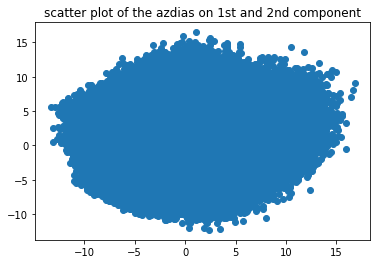

In [18]:
# scatter the data on first and second principle component of the population data.
z_1 = pca_y.transform(Y)
plt.scatter(z_1[:,0],z_1[:,1])
plt.title("scatter plot of the azdias on 1st and 2nd component")

In [19]:
print("the explained variance for 200 features: ",np.cumsum(pca_y.explained_variance_ratio_[:200])[-1])

the explained variance for 200 features:  0.921368065309


we can see that 200 features from the data can explain 92% of the data and it is enough for our analysis.

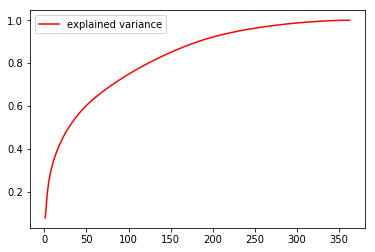

In [20]:
# the plot for cumulative explained variance 
plt.plot(range(1, Y.shape[1]+1), np.cumsum(pca_y.explained_variance_ratio_), color="red", label="explained variance")
plt.legend()

### Clustering of the Data

there are different approaches can be used for clustering the data. Here we use K-Mean clustering algorithm as it is the simplest and most favourite one among data scientists. 

the most important parameter for K_Mean clustering is the number of the clusters that we have to choose for algorithm. there are different approaches to regulize the number of clusters such as:

- elbow method
- silhouette score

we use elbow method for this data to find the optimal cluster numbers for thsi data. 

Num clusters 2 Inertia: 49087215.8059
Num clusters 3 Inertia: 47399213.5404
Num clusters 4 Inertia: 46490374.4208
Num clusters 5 Inertia: 45702513.2901
Num clusters 6 Inertia: 45085840.2024
Num clusters 7 Inertia: 44553278.6261
Num clusters 8 Inertia: 44119950.0556
Num clusters 9 Inertia: 43764682.1889
Num clusters 10 Inertia: 43465643.6961
Num clusters 11 Inertia: 43202979.4941


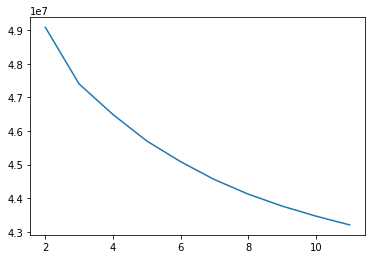

In [30]:
# we select ... clusters
all_kmeans = [i for i in range(10)]
for i in range(10):
    cur_kmeans = KMeans(i+2)
    cur_kmeans.fit(z_1[:,0:200])
    print("Num clusters", i+2, "Inertia:", cur_kmeans.inertia_)
    all_kmeans[i] = cur_kmeans
plt.plot([i+2 for i in range(10)], [all_kmeans[i].inertia_ for i in range(10)])

0
2


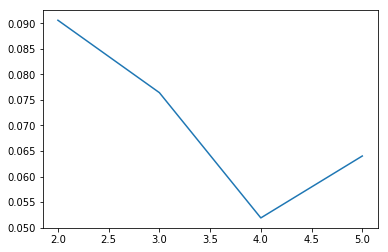

In [29]:
kmeans_cur = [i for i in range(5)]
for i in range(4):
    if i % 2==0:
        print(i)
    kmean = KMeans(n_clusters=i+2)
    kmean.fit(z_1[:100,0:60])
    kmeans_cur[i] = kmean
plt.plot([i+2 for i in range(4)], [silhouette_score(z_1[:100,0:60],kmeans_cur[i].labels_) for i in range(4)])

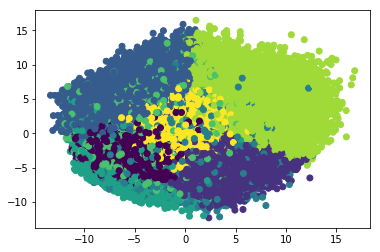

In [21]:
# 8 clusters: PCA plot
kmeans_y = KMeans(8, tol=1e-6)
kmeans_y.fit(z_1[:,0:200])
plt.scatter(z_1[:,0],z_1[:,1], c=kmeans_y.labels_)

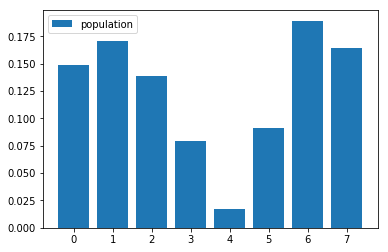

In [22]:
label_count_1 = [list(kmeans_y.labels_).count(i)/Y.shape[0] for i in range(0,8,1)]
plt.bar(range(0,8,1),label_count_1,label = "population")
plt.legend()

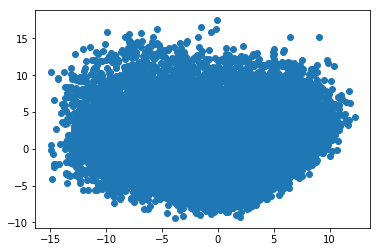

In [23]:
X = scaled_customers.iloc[:,1:-4]
z_2 = pca_y.transform(X)
plt.scatter(z_2[:,0],z_2[:,1])

In [25]:
preds = kmeans_y.predict(z_2[:,0:200])
label_count_2 = [list(preds).count(i)/X.shape[0] for i in range(0,8,1)]

Text(0,0.5,'proportions in clusters')

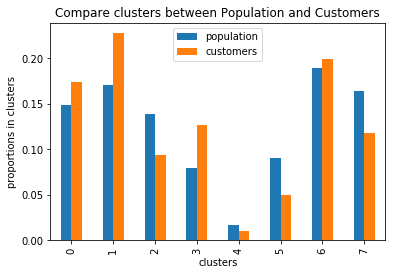

In [26]:
# plot the proprtion of people assigned to each cluster 
labels_df = pd.DataFrame({"population":label_count_1,"customers":label_count_2})
labels_df.plot(kind="bar")
plt.title("Compare clusters between Population and Customers")
plt.xlabel("clusters")
plt.ylabel("proportions in clusters")

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [27]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [91]:
mailout_train.shape

(42962, 367)

In [31]:
# clean mailout_train data 
cleaned_mailout_train = clean_data(mailout_train,drop_axis=1) # drop columns with nan values exceeding threshold

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
cleaned_mailout_train.shape

(42962, 362)

In [33]:
# seperate train and target variables and drop the id column LNR for training
x_train = cleaned_mailout_train.drop('RESPONSE',axis=1).iloc[:,1:]
y_train = cleaned_mailout_train['RESPONSE']

def predict_with_RandomForest(x_train,y_train):
    """
    fit the data on RandomForest regressior and predict for the train data 
    Args:
        x_train(pandas dataframe)- the pandas data frame containing the train data
        y_train(pandas series)- the target data which is the RESPONCE column of the mail_train data
        
    Return:
        modle_rf(sklearn RandomForest)- RandomForestRegressor model after fitting with train data
        preds_rf_train(numpy array)- array containing the predicted results for train data
    """
    
    model_rf = RandomForestRegressor(n_estimators=100, random_state=0)  # Instantiate with RandomForestRegressor 

    model_rf.fit(x_train, y_train) # fit
    
    #Predict wth Random Forest Regressor and return the scores for the model
    preds_rf_train = model_rf.predict(x_train)

    return model_rf,preds_rf_train

model_rf,preds_rf_train = predict_with_RandomForest(x_train,y_train)

In [87]:
# use sklearn roc_curve to Compute Receiver operating characteristic (ROC).
fpr, tpr, thresholds = metrics.roc_curve(y_train, preds_rf_train)
score = metrics.auc(fpr, tpr)
print("the prediction score for train data: ",score)

the prediction score for train data:  0.975603049871


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [46]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [47]:
# clean test data 
mailout_test_cleaned = clean_data(mailout_test,drop_axis=1)# drop columns with nan values exceeding threshold
mailout_test_cleaned.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,OST_WEST_KZ_W
0,1754.0,2.0,1.0,7.0,3.0,3.0,6.0,2.0,0.0,0.0,...,5.0,6.0,3.0,6.0,3.0,3.0,3.0,1.0,4.0,1.0
1,1770.0,3.0,1.0,0.0,3.0,3.0,0.0,20.0,0.0,0.0,...,5.0,2.0,1.0,6.0,3.0,5.0,3.0,1.0,4.0,1.0
2,1465.0,2.0,9.0,16.0,3.0,3.0,11.0,2.0,0.0,0.0,...,9.0,6.0,3.0,2.0,3.0,4.0,3.0,2.0,4.0,1.0
3,1470.0,2.0,7.0,0.0,2.0,2.0,0.0,1.0,0.0,0.0,...,6.0,6.0,3.0,2.0,2.0,2.0,3.0,2.0,4.0,0.0
4,1478.0,1.0,1.0,21.0,1.0,1.0,13.0,1.0,0.0,0.0,...,2.0,4.0,3.0,3.0,1.0,7.0,4.0,2.0,4.0,1.0


In [84]:
print("the shape of the mail_test data after cleaning:")
mailout_test_cleaned.shape

the shape of the mail_test data after cleaning:


(42833, 361)

In [49]:
x_test = mailout_test_cleaned.iloc[:,1:]

In [50]:
preds_test = model_rf.predict(x_test)

In [45]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, preds_rf_train)
metrics.auc(fpr, tpr)

1.0

In [54]:
preds_test

array([ 0.02,  0.06,  0.01, ...,  0.05,  0.07,  0.06])

In [78]:
test_result = pd.DataFrame({"LNR":mailout_test_cleaned["LNR"].astype(int),"RESPONSE" :preds_test})
test_result = test_result.set_index("LNR")

In [83]:
test_result.to_csv("predictions.csv")